<a href="https://colab.research.google.com/github/Spica08/deep-learning-from-scratch-5/blob/main/step7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# set up
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

!pip install torchviz
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchviz
from torchvision import datasets, transforms

from IPython.display import display

# step7 変分オートエンコーダ(VAE)

## 7.1 VAEとデコーダ

### 7.1.1 1つの正規分布
ここでは正規分布のパラメータを$\theta = \lbrace \mu, \sum\rbrace$で表す。データxの分布を1つの正規分布でモデル化する場合の確率分布は以下のようになる。
\begin{equation}
p_\theta(x) = \mathcal{N}(x;\theta)
\end{equation}
モデルのパラメータ推定では、N個の観測データ$D = \lbrace x^{(1)}, x^{(2)}, \dots, x^{(N)}\rbrace$から、以下の対数尤度が最大となるパラメータを求める。
\begin{equation}
log p_\theta(D) = log(p_\theta(x^{(1)})p_\theta(x^{(2)}) \dots p_\theta(x^{(N)}))
\end{equation}

### 7.1.2 混合ガウスモデル
GMMでは以下の2つの作業でデータを生成する。  
1. K個の正規分布の中から、カテゴリカル分布に従って1つを選ぶ  
2. 選んだ正規分布からデータを生成する  
GMMでは、対数尤度の最大化問題を解析的に解くことができないため、以下のELBOを目的関数とすることでパラメータを探索する。
\begin{align}
logp_\theta(D) &\ge \sum_{n = 1}^N \sum_{z(n)} q^{(n)}(z^{(n)}) log \frac{p_\theta(x^{(n)}, z^{(n)})}{q^{(n)}(z^{(n)})}
\end{align}

具体的には、EステップとMステップを以下のように繰り返すことで行う。  

Eステップ : $\theta$を固定し$\lbrace q^{(1)}, q^{(2)}, \dots, q^{(N)}\rbrace$を更新する。各nに対して$q^{(n)}(z) = p_\theta(z | x^{(n)})$と更新する  
Mステップ : q(z)を固定してパラメータ$\theta$を解析的に求める。

### 7.1.3 VAE
VAEはGMM同様に潜在変数を持つモデルで、以下の2つの作業でデータを生成する。  
1. 潜在変数zを固定の正規分布から生成する  
2. ニューラルネットワークによって潜在変数zから観測変数xへと変換する。  

ここで、潜在変数zはH次元のベクトルで表すこととする。  
$z = \begin{pmatrix}
   z_1 \\ z_2 \\ \vdots \\ z_D
\end{pmatrix}$  
また、VAEではzは平均0、共分散行列Iの正規分布から生成されると仮定する。このとき、「zは$\mathcal{N}(z;0,I)$に従う」といい、
\begin{equation}
p(z) = \mathcal{N}(z;0,I)
\end{equation}
と表す。GMMではzの分布が離散値だったのに対し、VAEでは連続値をサンプリングするためより多様化かつ広範な表現が可能になる。  

モデル化の目標は、観測変数xの確率分布p(x)を得ることである。そのため、zからxへの変換を行うニューラルネットワークは、確率分布としてP(x|z)をモデル化する必要がある一方、出力はベクトルに制限される。そこで、このギャップを埋めるために、「ニューラルネットワークの出力を平均ベクトルとする正規分布」を考える。数式では以下のように表す。
\begin{align}
\hat{x} &= NeuralNet(z;\theta)\\
p_\theta(x|z) &= \mathcal{N}(x;\hat{x},I)
\end{align}
以上がVAEのデコーダ部分の数式による表現となる。

### 7.1.4 EMアルゴリズムの問題点
VAEは理論上GMMと同様にEMアルゴリズムにより学習が可能なはずである。しかし、実際には計算量の制約により実現が困難となっている。  

EMアルゴリズムのEステップでは、パラメータを固定して$q^{(n)}(z) = p_\theta(z | x^{(n)})$という計算を行う必要がある。これをVAEで行おうとすると、
\begin{align}
p_\theta(z | x^{(n)}) &= \frac{p_\theta(x^{(n)}, z)}{p_\theta(x^{(n)})}\\
                      &= \frac{p_\theta(x^{(n)}, z)}{\int p_\theta(x^{(n)}, z)dz}
\end{align}
となる。分母の積分計算について、GMMの場合ではzが離散値だったために容易に計算可能だったが、離散値であるVAEの場合は多次元ベクトルzの取りうる値全てを考慮することは実質不可能であり計算できない。VAEではこの問題を解決する必要がある。

## 7.2 VAEとエンコーダ

### 7.2.1 EMアルゴリズムからVAEへ
EMアルゴリズムでは、任意の確率分布q(z)を用いて次のような式展開をした。
\begin{align}
logp_\theta(x) &= \left(\int q(z)dz \right) logp_\theta(x)\\
                &= \int q(z)logp_\theta(x)dz\\
                &= \int q(z)log \frac{p_\theta(x, z)}{p_\theta(z | x)}dz\\
                &= \int q(z)log \frac{p_\theta(x, z)}{p_\theta(z | x)} \frac{q(z)}{q(z)}dz\\
                &= \int q(z)log\frac{p_\theta(x, z)}{q(z)}dz + \int q(z)log\frac{q(z)}{p_\theta(z | x)}dz\\
                &= \int q(z)log\frac{p_\theta(x, z)}{q(z)}dz + D_{KL}(q(z) || p_\theta(z | x)\\
                &\ge \int q(z)log\frac{p_\theta(x, z)}{q(z)}dz \qquad (ELBO)
\end{align}
この式より、$ELBO(x;q,\theta)$を大きくするようにパラメータを更新すれば、元々の対数尤度$log p_\theta(x)$はそれ以上の値となる。よって手に負えない対数尤度の代わりにELBOを最適化の対象としていた。  

さらに、EMアルゴリズムでは、Eステップにおけるzの事後分布q(z)の更新として$q(z) = p_\theta(z | x)$を計算していた。しかしzが連続値であるVAEではこの更新のための計算も困難である(条件付き確率の分母にzの積分が登場する)。そこで、VAEでは次のアプローチを取る。  
1. q(z)を簡単な確率分布(正規分布)に限定する
2. その限定された確率分布の中でELBOの最適化を行う  

VAEの潜在変数zは実数のベクトルである。そこでその確率分布をq(z)に限定することにする。q(z)は平均ベクトル$\mu$と今日分散行列$\sum$という2つのパラメータを持つことになり、それを$\psi = \lbrace \mu, \sum\rbrace$として、
\begin{equation}
q_\psi(z) = \mathcal{N}(x;\mu, \sum)
\end{equation}
とする。  

このとき、先ほど示した対数尤度は以下のように表される。
\begin{align}
logp_\theta(x) &= \int q_\psi(z)log\frac{p_\theta(x, z)}{q_\psi(z)}dz + D_{KL}(q_\psi(z) || p_\theta(z | x)
\end{align}
このうちELBO項である
\begin{align}
ELBO(x;\theta, \psi) &= \int q_\psi(z)log\frac{p_\theta(x, z)}{q_\psi(z)}dz
\end{align}
を$\theta$と$\psi$について最大化することが目的となる。ここで重要な点は、ELBOを$\psi$に関して最大化すると、$q_\psi(z)$は$p_\theta(z | x)$に最も近づくという点である。GMMでは、q(z)を直接$p_\theta(z|x)$で更新することで両者は全く同じ分布とすることができた(KLダイバージェンス = 0)が、VAEではそれは困難なため$\psi$の最適化を通して両者をなるべく近づけることを行う。

### 7.2.2 データセット全体への適用
1つのデータから複数データ$\lbrace x^{(1)}, x^{(2)}, \dots, x^{(N)}\rbrace$へと拡張する。目的関数(ELBO)は以下の通り。GMM同様に潜在変数zの事後分布はデータごとに仮定して$\lbrace q_\psi^{(1)}, q_\psi^{(2)}, \dots, q_\psi^{(N)}\rbrace$とする。
\begin{align}
\sum_{n = 1}^N ELBO(x^{(n)}; \theta, \psi^{(n)}) &= \sum_{n = 1}^N \int q_\psi^{(n)}(z)log\frac{p_\theta(x^{(n)}, z)}{q_\psi^{(n)}(z)}dz
\end{align}

ここで1つ問題となるのが、各データごとに事後分布を仮定するために、データが巨大になればその分大量のパラメータを仮定しなければならないことである(GMMでも同じことが言えそうな気がするが、、、？)。この問題を解決するためにもニューラルネットワークが活躍する。  

パラメータについて考えると、各データ$x^{(n)}$に対して正規分布のパラメータ$\lbrace \mu^{(n)}, \sum^{(n)}\rbrace$が存在することとなる。そこで、入力が$x^{(n)}$、出力が$\lbrace \mu^{(n)}, \sum^{(n)}\rbrace$とみなしてニューラルネットワークで代用することを考える。これにより1つのニューラルネットワークにより各データにふさわしい正規分布のパラメータを出力させることが可能になる。

この、入力が$x^{(n)}$、出力が$\lbrace \mu^{(n)}, \sum^{(n)}\rbrace$であるニューラルネットワークのパラメータを$\phi$とおく。これは、観測変数xから潜在変数zの事後分布を計算するためのものであり、
エンコーダと呼ばれる。適切に学習されたニューラルネットワークであれば、$x^{(n)}$にふさわしい$\lbrace \mu^{(n)}, \sum^{(n)}\rbrace$を出力することが可能である。これにより、データごとにq(z)の事後分布を設定する代わりに、1つのニューラルネットワークのパラメータ$\phi$のみを考えることになる。このように、近似事後分布のパラメータを1つのニューラルネットワークで計算する手法を**償却理論(Amortized Inference)**と呼ぶ。

潜在変数zが次元数Hのベクトルだとすると、エンコーダのニューラルネットワークの出力$\mu$もH次元のベクトルになる。共分散行列$\sum$はH * Hの行列になるが、計算コスト削減のため、非対角成分が全て0の対角共分散行列と仮定する。これにより、$\sum$のH個の対角成分のみからなるベクトルを出力すれば十分となる。そこでエンコーダ用のニューラルネットワークは次の2つのベクトルを出力することとなる。  
$\mu = \begin{pmatrix}
   \mu_1 \\ \mu_2 \\ \vdots \\ \mu_D
\end{pmatrix}$  

$\sigma = \begin{pmatrix}
   \sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_D
\end{pmatrix}$  

以上より、VAEのエンコーダで行う処理は以下のようになる。
\begin{align}
\mu, \sigma &= NeuralNet(x;\phi)\\
q_\phi(z | x) &= \mathcal{N}(z;\mu, \sigma^2I)
\end{align}
q(z)の事後分布に関して、GMMではデータごとに仮定したためn番目のデータが得られている時の事後分布として$q^{(n)}(z)$と表記していたが、VAEではデータセットに対して1つのニューラルネットワーク(1つのパラメータ)を考えてzの事後分布を計算するため$q_\phi(z|x)$という表記になる。

## 7.3 ELBOの最適化
デコーダ
\begin{align}
p(z) &= \mathcal{N}(z;0,I)\\
\hat{x} &= NeuralNet(z;\theta)\\
p_\theta(x|z) &= \mathcal{N}(x;\hat{x},I)
\end{align}
エンコーダ
\begin{align}
\mu, \sigma &= NeuralNet(x;\phi)\\
q_\phi(z | x) &= \mathcal{N}(z;\mu, \sigma^2I)
\end{align}

エンコーダは、データxが与えられた時のzの事後分布$q_\phi(z | x)$をモデル化し、デコーダはサンプリングされた潜在変数zが与えられた時のxの確率分布$p_\theta(x | z)$をモデル化する。  


ここでの目標はこの2つのニューラルネットワークを用いたモデルにおいて、対数尤度を最大化するパラメータ$\theta$、$\phi$を見つけることである。対数尤度そのものは最適化できないので、代わりにELBOの最大化を考える。
\begin{align}
\sum_{n = 1}^N ELBO(x^{(n)}; \theta, \phi) &= \sum_{n = 1}^N \int q_\phi(z | x^{(n)})log\frac{p_\theta(x^{(n)}, z)}{q_\phi(z | x^{(n)})}dz
\end{align}

### 7.3.1 ELBOの評価
1つのデータxに対応するELBOについて考えると以下のように展開できる。
\begin{align}
ELBO(x;\theta, \phi) &= \int q_\phi(z | x)log\frac{p_\theta(x, z)}{q_\phi(z | x)}dz\\
                     &= \int q_\phi(z | x)log\frac{p_\theta(x | z)p(z)}{q_\phi(z | x)}dz \qquad \because z は\thetaに依存しない\\
                     &= \int q_\phi(z | x)logp_\theta(x | z)dz + \int q_\phi(z | x)log\frac{p(z)}{q_\phi(z | x)}dz\\
                     &= \int q_\phi(z | x)logp_\theta(x | z)dz - \int q_\phi(z | x)log\frac{q_\phi(z | x)}{p(z)}dz\\
                     &= \mathbb{E}_{q_\theta(z | x)}[logp_\theta(x | z)] - D_{KL}(q_\phi(z | x) || p(z))
\end{align}
以下のように$J_1, J_2$を定め以下の式変形を行う。
\begin{align}
J_1 &= \mathbb{E}_{q_\theta(z | x)}[logp_\theta(x | z)] \\
J_2 &= D_{KL}(q_\phi(z | x) || p(z))
\end{align}

$J_1$は期待値なのでモンテカルロ法によって近似できる。VAEではサンプルサイズが1でも上手くいくケースが多い。サンプルサイズを1とすると、$z \backsim q_\theta(z | x)$によってzを1つサンプリングし、その時の$logp_\theta(x | z)$を計算すれば良い。
\begin{align}
\mu, \sigma &= NeuralNet(x;\phi)\\
z &\backsim \mathcal{N}(z;\mu, \sigma^2I)\\
\hat{x} &= NeuralNet(z;\theta)\\
J_1 &\approx log\mathcal{N}(x;\hat{x}, I)\\
    &= log \left(\frac{1}{\sqrt{(2\pi)^D}|I|}exp\left(-\frac{1}{2}(x - \hat{x})^TI^{-1}(x - \hat{x}) \right)\right)\\
    &= -\frac{1}{2}(x - \hat{x})^T(x - \hat{x}) + const\\
    &= -\frac{1}{2} \sum_{d = 1}^D(x_d - \hat{x}_d)^2 + const
\end{align}
よってこの項は元のデータxと、encoder, decoderにより再構成されたデータ$\hat{x}$の2乗誤差が小さいほど大きくなる。そのため「再構成誤差項」と呼ばれる。

$J_2$はKLダイバージェンスである。係数が負であるこの項はできるだけ0に近づく事が望ましい。2つの正規分布に関するKLダイバージェンスより、
\begin{align}
J_2 &= D_{KL}(q_\phi(z | x) || p(z))\\
     &= D_{KL}(\mathcal{N}(z;\mu, \sigma^2I) || \mathcal{N}(z;0, I))\\
     &= -\frac{1}{2}\sum_{h = 1}^H(1 + log\sigma_h^2 - \mu_h^2 - \sigma_h^2)
\end{align}
この項は、データxが得られた時のzの事後分布があらかじめ設定したp(z)の事前分布に近づくほど小さくなる(ELBOは大きくなる)。したがって「整合性項」と呼ばれる。この時、$q_\psi(z | x)$は、真の事後分布$p_\theta(z | x)$とp(z)の両方に近づくように学習が進むことになる。

以上よりELBOは以下のように計算できる。
\begin{equation}
ELBO(x;\theta, \phi) \approx -\frac{1}{2} \sum_{d = 1}^D(x_d - \hat{x}_d)^2 + \frac{1}{2}\sum_{h = 1}^H(1 + log\sigma_h^2 - \mu_h^2 - \sigma_h^2) + const
\end{equation}
このELBOを最大化するNNのパラメータ$\theta, \phi$を学習することになる。

### 7.3.2 変数変換トリック
上記のモデルのままでは、潜在変数zをサンプリングする過程があるため、計算グラフが微分不可能隣誤差逆伝播法が使えない。そこで**変数変換トリック**を用いて解決する。  

変数変換トリックでは、$z \backsim \mathcal{N}(z;\mu, \sigma^2I)$のサンプリングを以下のように計算する。
\begin{align}
\epsilon &\backsim \mathcal{N}(\epsilon; 0,I)\\
z &= \mu + \sigma \odot \epsilon
\end{align}
実際にベクトルの要素を表示して確認すると、
\begin{align}
z &= \mu + \sigma \odot \epsilon\\
  &= \begin{pmatrix}\mu_1 \\ \mu_2 \\ \vdots \\ \mu_H \end{pmatrix} + \begin{pmatrix}\sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_H \end{pmatrix} \odot \begin{pmatrix}\epsilon_1 \\ \epsilon_2 \\ \vdots \\ \epsilon_H \end{pmatrix}\\
  &= \begin{pmatrix}\mu_1 + \sigma_1\epsilon_1 \\ \mu_2 + \sigma_2\epsilon_2 \\ \vdots \\ \mu_H + \sigma_H\epsilon_H \end{pmatrix}
\end{align}
この計算によって得られるzは$z \backsim \mathcal{N}(z;\mu, \sigma^2I)$からサンプリングした値と同じ分布に従う。これによりサンプリングを計算グラフの外にする事が可能となり勾配を計算できるようになる。

## 7.4 VAEの実装

### 7.4.1 実装の方針
\begin{equation}
ELBO(x;\theta, \phi) \approx -\frac{1}{2} \sum_{d = 1}^D(x_d - \hat{x}_d)^2 + \frac{1}{2}\sum_{h = 1}^H(1 + log\sigma_h^2 - \mu_h^2 - \sigma_h^2) + const
\end{equation}
上記のELBOに対して、以下のように損失関数を設定する。
\begin{equation}
ELBO(x;\theta, \phi) \approx \sum_{d = 1}^D(x_d - \hat{x}_d)^2 - \sum_{h = 1}^H(1 + log\sigma_h^2 - \mu_h^2 - \sigma_h^2)
\end{equation}

### 7.4.2 VAEのコード

In [2]:
# hyper parameter
input_dim = 784
hidden_dim = 200
latent_dim = 20 # 潜在変数の次元数
epochs = 30
learning_rate = 3e-4
batch_size = 32

In [21]:
# encoderの実装
# 入力を線形層/活性化層に通してmu, sigmaを出力する
# sigmaについて、sigmaを直接出力させることもできるが、要素が全て正であるという制約がつく。
# そこで、分散の対数log(sigma^2)を出力させることで値域の制約を無くす事ができる。
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        sigma = torch.exp(0.5 * logvar) # 本来のsigmaに戻す
        return mu, sigma

In [16]:
# decoderの実装
# MNISTのoutputに合うように最後の出力層はsigmoid関数とする
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.linear1(z)
        z = F.relu(z)
        z = self.linear2(z)
        x_hat = F.sigmoid(z)
        return x_hat

In [23]:
# VAEの実装

# 変数変換トリック
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + eps * sigma

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction = 'sum')
        L2 = -torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

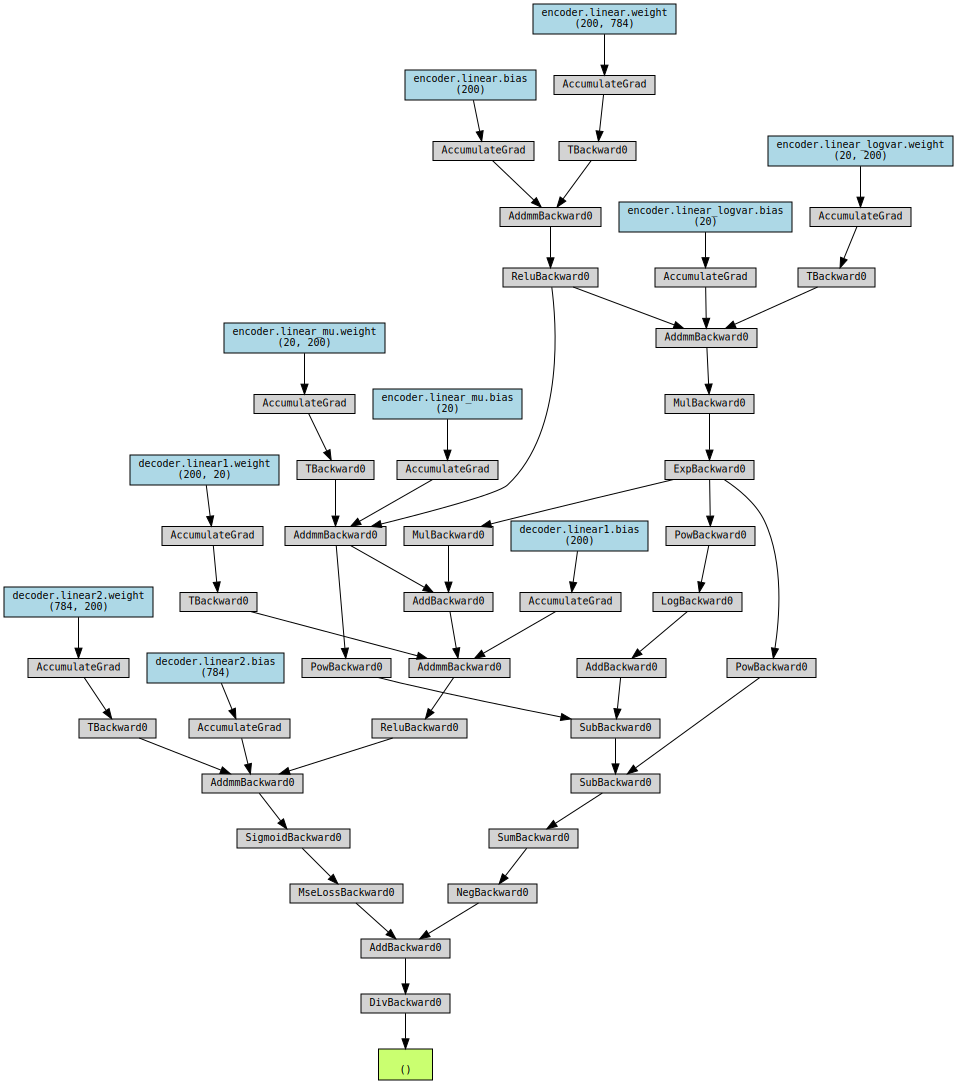

In [25]:
# 計算グラフ確認
model = VAE(input_dim, hidden_dim, latent_dim)
x = torch.randn(1, 28 * 28)
y = model.get_loss(x)
img = torchviz.make_dot(y, params=dict(model.named_parameters()))
display(img)